In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import zoom
from sklearn import linear_model
from scipy.ndimage.filters import gaussian_filter as gf

from hyss_util import *

In [49]:
# --  MCMC sampling
!pip install emcee
import emcee

In [50]:
!pip install corner
import corner

In [3]:
# -- matplotlib defaults
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gist_gray"

In [4]:
# -- load templates
names = np.load("../output/final_lab_spectra_names.npy", allow_pickle = True)
spectra = np.load("../output/final_lab_spectra.npy").T
waves = np.load("../output/final_lab_spectra_wavelengths.npy")

In [109]:
# # -- get the HPS category
templsin_df = pd.DataFrame(templsin)
templsin_df["name"] = names
HPS_temp = templsin_df[templsin_df["name"].str.contains("HPS")]
HPS_temp = HPS_temp.iloc[:, :848].values
HPS_temp[:, 847]

array([0.00231399, 0.00094466, 0.        ])

In [5]:
# -- load waves range for both scans
wave0 = np.load("../output/graham_hall_upload/cube0_waves_range.npy")
wave1 = np.load("../output/graham_hall_upload/cube1_waves_range.npy")

In [55]:
# -- load aggregate spectra
spectrum_2013 = np.load("../output/aggregate_no_constructions_2013.npy")
spectrum_2018 = np.load("../output/aggregate_no_constructions_2018.npy")

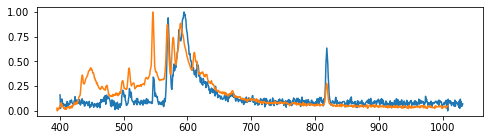

In [56]:
fig, ax = plt.subplots(figsize = (8, 2))
ax.plot(wave0, spectrum_2013)
ax.plot(wave1, spectrum_2018)

In [57]:
# -- interpolate the 2013 aggregate spectra
interp_2013 = np.interp(wave1, wave0, spectrum_2013)
# -- interpolate the NOAA and lspdd lab spectra wavelengths (x-coordinates) to the wavelengths of the HSI scan
templsin = np.array([np.interp(wave1, waves, i) for i in spectra])

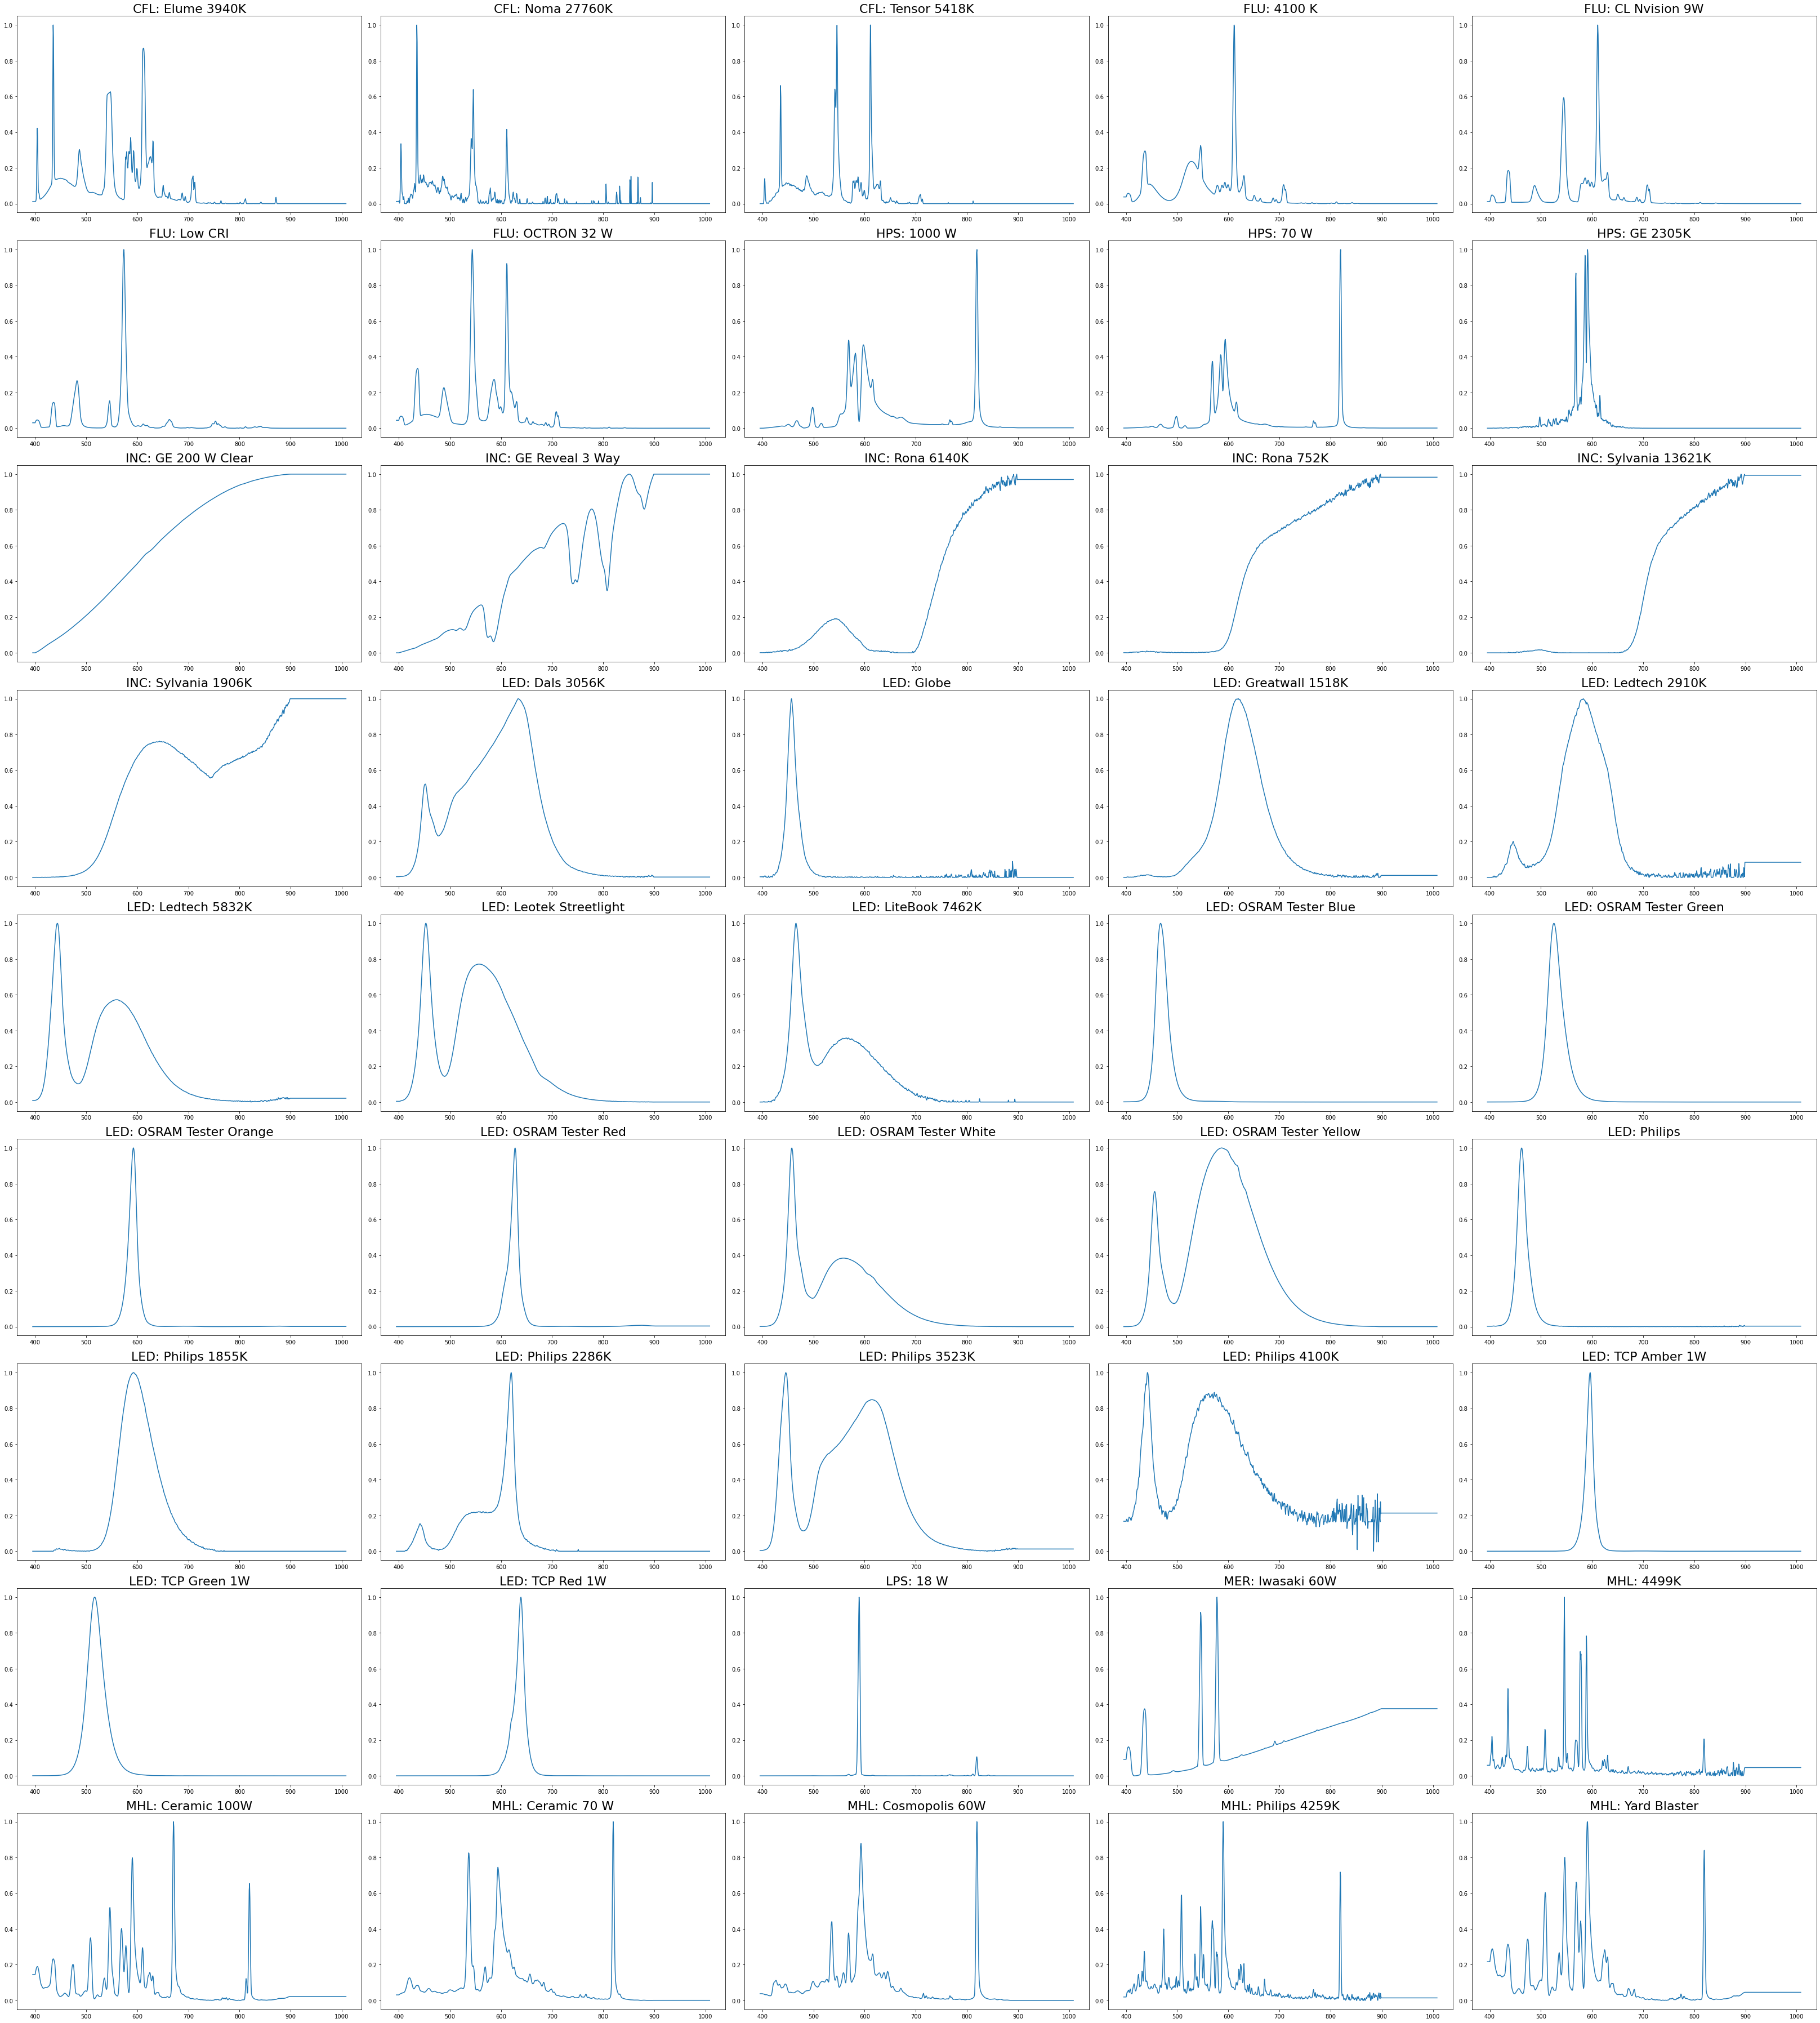

In [14]:
# -- let's plot LSPDD spectra
fig, ax = plt.subplots(nrows=9, ncols=5, figsize = (45,50))
num = 0
for i in range(0, 9):
  for j in range(0, 5):
    ax[i, j].set_title(names[num], fontsize=22)
    ax[i, j].plot(wave1, templsin[num])
    num = num + 1
    if num == 45:
      break

fig.tight_layout()

In [58]:
# -- since both aggregate spectra and templates are all normalized
# let's prepare a dataframe for coef calculation
def coef_cal(templs, aggre_spec, waves, num):
    
    templsin_df = pd.DataFrame(templs).T
    templsin_df["aggre_spec"] = aggre_spec
    templsin_df["wave"] = waves
    templsin_df = templsin_df.set_index("wave")
    X = templsin_df.iloc[:, :num]
    y = templsin_df["aggre_spec"]



    # Initialize model from sklearn and fit it into our data
    regr = linear_model.LinearRegression()
    model = regr.fit(X, y)

    offset = model.intercept_
    coef = model.coef_
    
    return coef, offset

coef2013, offset2013 = coef_cal(templsin, interp_2013, wave1, 45)
coef2018, offset2018 = coef_cal(templsin, spectrum_2018, wave1, 45)

In [114]:
# coef2013_hps, offset2013_hps = coef_cal(HPS_temp, spectrum_2018, wave1, 3)

In [62]:
# -- replace the negative value to 0.00000000000000001


def replace_negative(coef, offset):
    
    coef_list = list(coef)
    

    # -- change the negative initial coef to 0.00000000000000001
    para = []

    for num in coef_list:
        if num < 0:
            num = 0.00000000000000001
            
        else:
            num = num
        para.append(num)
    para.append(offset)
    para.append(0.05)
    
    return para

In [63]:
para_2013 = replace_negative(coef2013, offset2013)
para_2018 = replace_negative(coef2018, offset2018)

In [116]:
# para_2013_hps = replace_negative(coef2013_hps, offset2013_hps)

In [66]:
# -- set initial value
x = pd.DataFrame(templsin).T

# -- change the index to wavelength
x["wave"] = wave1
x = x.set_index("wave")

x.shape

(848, 45)

In [81]:
def log_likelihood(theta, x, y, yerr):
    coef0, coef1, coef2, coef3, coef4, coef5, coef6, coef7, coef8, coef9, coef10, \
    coef11, coef12, coef13, coef14, coef15, coef16, coef17, coef18, coef19,  coef20, \
    coef21, coef22, coef23, coef24, coef25, coef26, coef27, coef28, coef29, coef30, \
    coef31, coef32, coef33, coef34, coef35, coef36, coef37, coef38, coef39, coef40, \
    coef41, coef42, coef43, coef44,\
    offset, log_f = theta
    model = np.multiply(theta[:45], x).sum(axis =1) + offset
    sigma2 = yerr ** 2
    #+ model ** 2 * np.exp(2 * log_f)

    return -0.5 * np.sum((y - model) ** 2 / sigma2)
                        # + np.log(2 * np.pi * sigma2))

def log_prior(theta):
    coef0, coef1, coef2, coef3, coef4, coef5, coef6, coef7, coef8, coef9, coef10, \
    coef11, coef12, coef13, coef14, coef15, coef16, coef17, coef18, coef19,  coef20, \
    coef21, coef22, coef23, coef24, coef25, coef26, coef27, coef28, coef29, coef30, \
    coef31, coef32, coef33, coef34, coef35, coef36, coef37, coef38, coef39, coef40, \
    coef41, coef42, coef43, coef44,\
    offset, log_f = theta

    if 0 < coef0 < np.inf and 0 < coef1 < np.inf and 0 < coef2 < np.inf and 0 < coef3 < np.inf and \
    0 < coef4 < np.inf and 0 < coef5 < np.inf and 0 < coef6 < np.inf and 0 < coef7 < np.inf and \
    0 < coef8 < np.inf and 0 < coef9 < np.inf and 0 < coef10 < np.inf and 0 < coef11 < np.inf and \
    0 < coef12 < np.inf and 0 < coef13 < np.inf and 0 < coef14 < np.inf and 0 < coef15 < np.inf and \
    0 < coef16 < np.inf and 0 < coef17 < np.inf and 0 < coef18 < np.inf and 0 < coef19 < np.inf and  \
    0 < coef20 < np.inf and 0 < coef21 < np.inf and 0 < coef22 < np.inf and 0 < coef23 < np.inf and \
    0 < coef24 < np.inf and 0 < coef25 < np.inf and 0 < coef26 < np.inf and 0 < coef27 < np.inf and \
    0 < coef28 < np.inf and 0 < coef29 < np.inf and 0 < coef30 < np.inf and 0 < coef31 < np.inf and \
    0 < coef32 < np.inf and 0 < coef33 < np.inf and 0 < coef34 < np.inf and 0 < coef35 < np.inf and \
    0 < coef36 < np.inf and 0 < coef37 < np.inf and 0 < coef38 < np.inf and 0 < coef39 < np.inf and \
    0 < coef40 < np.inf and 0 < coef41 < np.inf and 0 < coef42 < np.inf and 0 < coef43 < np.inf and \
    0 < coef44 < np.inf and \
    -np.inf < offset < np.inf and -np.inf < log_f < np.inf:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


# -- set the initial starting points for the MCMC walkers
# # -- for 2013
# cc_st =  np.array(para_2013)

# -- for 2018
cc_st =  np.array(para_2018)

pos = cc_st + 1e-4 * np.random.randn(100, 47)
nwalkers, ndim = pos.shape
xf

# -- set up the MCMC sampler
# # -- for 2013
# sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, interp_2013, 0.05))

# -- for 2018
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, spectrum_2018, 0.05))

# -- run the sampler
sampler.run_mcmc(pos, 18000, progress=True)

100%|███████████████████████████████████| 18000/18000 [00:16<00:00, 1106.29it/s]


State([[ 5.77850259e-05  1.37011605e-04  1.12575630e-01 ...  1.14923824e-01
  -2.46781673e-02  4.98927238e-02]
 [-1.88202719e-04 -1.33816608e-07  1.12498370e-01 ...  1.14979641e-01
  -2.46648689e-02  4.99684543e-02]
 [-1.62549659e-05 -6.35505742e-05  1.12463352e-01 ...  1.14925199e-01
  -2.45561771e-02  5.01629850e-02]
 ...
 [ 1.16949626e-04  4.76403790e-06  1.12507872e-01 ...  1.14921232e-01
  -2.46588610e-02  5.00212993e-02]
 [-6.20307013e-05  3.25685644e-04  1.12475012e-01 ...  1.14953317e-01
  -2.46673039e-02  5.00467840e-02]
 [ 3.31635870e-05  1.40258901e-04  1.12549906e-01 ...  1.15005730e-01
  -2.47148613e-02  4.99861965e-02]], log_prob=[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -in

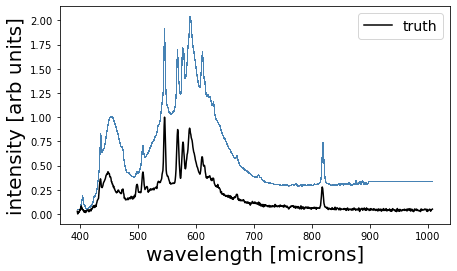

In [82]:
flat_samples = sampler.get_chain(discard=5000, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=1000)

for ind in inds:
    sample = flat_samples[ind]
    model = np.multiply(sample[:45], x).sum(axis = 1) + sample[45]
    plt.plot(model, c = "steelblue", linewidth=0.2)
    
    
plt.plot(wave1, spectrum_2018, "k", label="truth")

plt.legend(fontsize=14)
plt.ylabel('intensity [arb units]', fontsize = 20)
plt.xlabel('wavelength [microns]', fontsize = 20)
plt.show()